In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
import xgboost as xgb

/home/ab/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Class

In [2]:
class Visualization:

    def distView(data,size=(9,8),bin=100):
        plt.figure(figsize=(9,8))
        return sns.distplot(data, bins=bin, hist_kws={'alpha': 0.4})

class Data(Visualization):
    def __init__(self,train,test):
        self.test = test
        self.train = train
        print('train : ' + str(self.train.shape))
        print('test: ' + str(self.test.shape))
        
    def describe(self,test=False):
        if test:
            return self.train.describe(), self.test.describe()
        return self.train.describe()
    
    def columns(self):
        return [i for i in self.test.columns if i not in ['connection_id','target']]
    
    def getCustom(self,substring):
        return [i for i in self.columns() if substring in i]

    def drop(self,colName):
        self.train = self.train.drop(colName,axis=1)
        self.test = self.test.drop(colName,axis=1)

    def scaler(self,colName):
        from sklearn.preprocessing import StandardScaler
        std_scale = StandardScaler().fit(self.test[colName])
        self.test[colName] = std_scale.transform(self.test[colName])
        self.train[colName] = std_scale.transform(self.train[colName])

    def decomposition(self):
        classSet = list(set(self.train['target']))
        self.classDict = { i: [1 if j==i else 0 for j in self.train['target']] for i in classSet}

In [3]:
class XGBoostClassifier():
    def __init__(self,num_rounds, **params):
        self.clf = None
        self.num_rounds = num_rounds
        self.params = params

    def fit(self, X, y):
        dtrain = xgb.DMatrix(X, y)
        self.clf = xgb.train(params=self.params, dtrain=dtrain,num_round = self.num_rounds)

    def predict(self, X):
        dtest = xgb.DMatrix(X)
        return self.clf.predict(dtest)

#     def score(self, X, y):
#         Y = self.predict_proba(X)
#         return 1 / logloss(y, Y)

    def get_params(self, deep=True):
        return self.params

    def set_params(self, **params):
        self.params.update(params)
        return self

In [4]:
class SklearnHelper(object):
    def __init__(self,clf,seed=0,params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self,x_train,y_train):
        return self.clf.fit(x_train,y_train)
        
    def predict(self,x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importance(self,x,y):
        return self.clf.fit(x,y).feature_importances_

In [5]:
class level2:
    import xgboost as xgb
    def __init__(self,train,test,label,params):
        self.train = np.concatenate(train, axis=1)
        self.test = np.concatenate(test, axis=1)
        self.label = label
        self.params = params
        
    def train(self,num_round=600):
        dtrain = xgb.DMatrix(data=self.train, label=self.label)
        self.clfXgb = xgb.train(self.params, dtrain, num_round,maximize=True)
        return self.clfXgb
    
    def predict(self):
        dtest = xgb.DMatrix(data=x_test)
        return self.clfXgb.predict(dtest)
    

# Preloding and Functions

In [6]:
data = Data(pd.read_csv('../Data/bestTrain.csv'),pd.read_csv('../Data/bestTest.csv'))

train : (169307, 22)
test: (91166, 21)


In [7]:


ntest = data.test.shape[0]
ntrain = data.train.shape[0]
SEED = 6734637
NFOLDS = 5
kf_tr = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)
kf_ts = KFold(ntest, n_folds= NFOLDS, random_state=SEED)

def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    print('New Tranning Started')
    for (train_index_tr,test_index_tr),(train_index_ts,test_index_ts) in zip(kf_tr,kf_ts):
        print('New Fold Started')
        x_tr = x_train[train_index_tr]
        y_tr = y_train[train_index_tr]
        x_te_tr = x_train[test_index_tr]
        x_te_ts = x_test[test_index_ts]
        clf.train(x_tr,y_tr)
        oof_train[test_index_tr] = clf.predict(x_te_tr)
        oof_test[test_index_ts] = clf.predict(x_te_ts)
    return oof_train.reshape(-1,1),oof_test.reshape(-1,1)


def get_XGoof(params, x_train, y_train, x_test,num_rounds=None):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    print('New Tranning Started')
    for (train_index_tr,test_index_tr),(train_index_ts,test_index_ts) in zip(kf_tr,kf_ts):
        print('New Fold Started')
        dtrain = xgb.DMatrix(data=x_train[train_index_tr], label=y_train[train_index_tr])
        dte = xgb.DMatrix(data=x_train[test_index_tr])
        dtest = xgb.DMatrix(data=x_test[test_index_ts])   
        
        bst = xgb.train(params,dtrain,num_boost_round=num_rounds)
        oof_train[test_index_tr] = bst.predict(dte)
        oof_test[test_index_ts] = bst.predict(dtest)
        
    return oof_train.reshape(-1,1),oof_test.reshape(-1,1)

# Code

# Let us stack now
### Ready the parameters for ensembles

In [8]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
#      'warm_start': True, 
     #'max_features': 0.2,
#     'max_depth': 6,
    'min_samples_leaf': 50,
#     'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
#     'max_depth': 8,
    'min_samples_leaf': 50,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.25,
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0,
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'rbf',
    'C' : 0.025,
    }

In [34]:
params = {}
params = {}
params['objective'] = 'multi:softmax'
# params['eta'] = 0.0025 # .0075 1100 .0025 2000 .01 630
params['silent'] = True
params['max_depth'] = 6
params['subsample'] = 0.9
params['colsample_bytree'] = 0.9
params['nthread']=4
params['num_class']=3

params1 = {}
params1['objective'] = 'multi:softmax'
params1['eta'] = 0.01
params1['silent'] = True
params1['max_depth'] = 6
params1['subsample'] = 0.9
params1['colsample_bytree'] = 0.9
params1['nthread']=4
params1['num_class']=3

# default parameters
params2 = {}
params2['objective'] = 'multi:softmax'
params2['eta'] = 0.0075
params2['silent'] = True
params2['max_depth'] = 6
params2['subsample'] = 0.9
params2['colsample_bytree'] = 0.9
params2['nthread']=4
params2['num_class']=3

# default parameters
params3 = {}
params3['objective'] = 'multi:softmax'
params3['eta'] = 0.01
params3['silent'] = True
params3['max_depth'] = 7
params3['subsample'] = 0.9
params3['colsample_bytree'] = 0.9
params3['nthread']=4
params3['num_class']=3

# default parameters
params4=dict(params3)
params4['eta']=.0075
params4['max_depth']=6

params5=dict(params3)
params5['eta']=.0075
params5['max_depth']=7
# clf7=CustomXGboost(params=params1,num_boost_round=631,maximize=True)
# clf8=CustomXGboost(params=params2,num_boost_round=884,maximize=True)
# clf9=CustomXGboost(params=params3,num_boost_round=604,maximize=True)


In [10]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
# ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
# svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

# Numpy array for test and train

In [39]:
y_train = data.train['target'].ravel()
train = data.train[data.columns()]
x_train = train.values # Creates an array of the train data
x_test = data.test[data.columns()].values # Creats an array of the test data

## First level predection

In [12]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
print('completed')
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
print('completed')
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
print('Completed')

New Tranning Started
New Fold Started
New Fold Started
New Fold Started
New Fold Started
New Fold Started
completed
New Tranning Started
New Fold Started
New Fold Started
New Fold Started
New Fold Started
New Fold Started
completed
New Tranning Started
New Fold Started
New Fold Started
New Fold Started
New Fold Started
New Fold Started
Completed


In [18]:
xg1_oof_train, xg1_oof_test = get_XGoof(params1,x_train,y_train,x_test,num_rounds=631)
xg2_oof_train, xg2_oof_test = get_XGoof(params2,x_train,y_train,x_test,num_rounds=850)
# print('completed')
xg3_oof_train, xg3_oof_test = get_XGoof(params3,x_train,y_train,x_test,num_rounds=604)
# print('completed')
xg4_oof_train, xg4_oof_test = get_XGoof(params4,x_train,y_train,x_test,num_rounds=900)
# xg5_oof_train, xg5_oof_test = get_XGoof(params5,x_train,y_train,x_test,num_rounds=930)
xg6_oof_train, xg6_oof_test = get_XGoof(params4,x_train,y_train,x_test,num_rounds=2017)

In [17]:
xg5_oof_train

array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 1.],
       [ 0.],
       [ 1.]])

In [88]:
base_predictions_train = pd.DataFrame( {'RandomForest1': rf_oof_train.ravel(),
     'ExtraTrees1': et_oof_train.ravel(),
#      'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost1': gb_oof_train.ravel(),
      'xgb1': xg1_oof_train.ravel(),
      'xgb2': xg1_oof_train.ravel(),                                                                
      'xgb3': xg1_oof_train.ravel(),                                                               
      'xgb4': xg1_oof_train.ravel(),                                                                 
      'xgb5': xg1_oof_train.ravel(),
       'percep': per1_oof_train.ravel(),
#       'connection_id' : data.train['connection_id']                                  
    })

base_predictions_test = pd.DataFrame( {'RandomForest1': rf_oof_test.ravel(),
     'ExtraTrees1': et_oof_test.ravel(),
#      'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost1': gb_oof_test.ravel(),
      'xgb1': xg1_oof_test.ravel(),
      'xgb2': xg1_oof_test.ravel(),                                                                
      'xgb3': xg1_oof_test.ravel(),                                                               
      'xgb4': xg1_oof_test.ravel(),                                                                 
      'xgb5': xg1_oof_test.ravel(), 
     'percep': per1_oof_test.ravel(),
#       'connection_id' : data.test['connection_id']     
                                        
    })
# base_predictions_train.head()

In [54]:
base_predictions_train.to_csv('NewModel22:19-30_11Train.csv',index=None)
base_predictions_test.to_csv('NewModel22:19-30_11Test.csv',index=None)

In [ ]:
base_predictions_train.head()

# Lets see the corelearion of new features generated

In [15]:
def plotHeatMap(df, size=(16,9),an=True):
    plt.figure(figsize=size)
    cmap = plt.cm.viridis
    sns.heatmap(df.corr(),cmap=cmap,linewidths=0.1,vmax=1, linecolor="white", square=True,annot=an)
    plt.show()

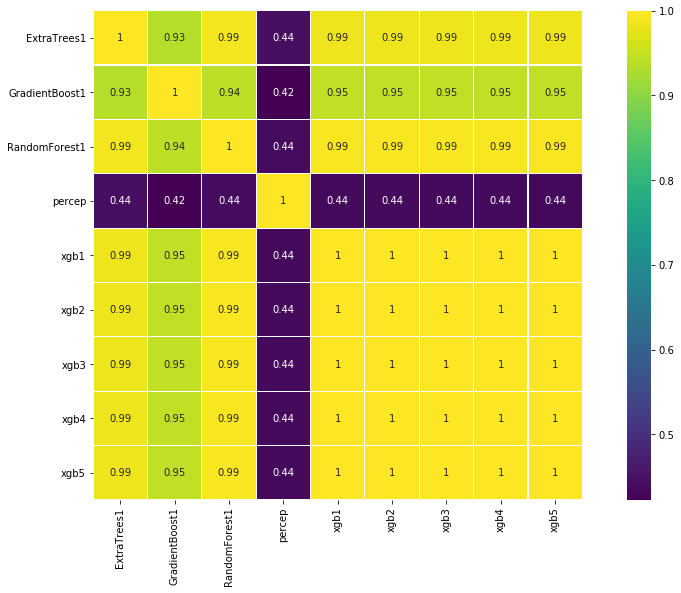

In [93]:
plotHeatMap(base_predictions_test)

In [25]:
params = {}
params['objective'] = 'multi:softmax'
params['eta'] = 0.0075
params['silent'] = True
params['max_depth'] = 6
params['subsample'] = 0.9
params['colsample_bytree'] = 0.9
params['nthread']=4
params['num_class']=3

In [26]:
x_train = np.concatenate(( xg1_oof_train, xg2_oof_train, xg3_oof_train, xg4_oof_train,xg5_oof_train,et_oof_train,rf_oof_train,gb_oof_train), axis=1)
x_test = np.concatenate(( xg1_oof_test, xg2_oof_test, xg3_oof_test, xg4_oof_test,xg5_oof_test,et_oof_test,rf_oof_test,gb_oof_test), axis=1)
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dtest = xgb.DMatrix(data=x_test)

In [27]:
clf1_2 = xgb.train(params, dtrain, 874,maximize=True)

In [28]:
pred = clf1_2.predict(dtest)

In [31]:
sub = pd.read_csv('../Data/sample_submission.csv')
sub['target'] = pred
sub['target'] = sub['target'].astype(int)
sub[['connection_id','target']].to_csv('8layerlevel1.csv', index=False)

In [32]:
data.train.columns

Index(['connection_id', 'cont_1', 'cont_2', 'cont_3', 'cont_8', 'cont_9',
       'cont_10', 'cont_11', 'cont_12', 'cont_13', 'cont_14', 'cat_1', 'cat_2',
       'cat_3', 'cat_9', 'cat_20', 'cat_22', 'cat_23', 'target',
       'cont_17_18_mean', 'cont_15_16_min', 'is_attack_1'],
      dtype='object')

In [33]:
x_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [35]:
from sklearn.linear_model import Perceptron

In [90]:
per1_params = {
    'penalty': 'elasticnet',
    'shuffle' : True,
    'n_jobs': -1,
#     'tol': 1e-5,
    'max_iter' : 1000,
     'tol' : 0.001
}

In [91]:
per1 = SklearnHelper(clf=Perceptron, seed=SEED, params=per1_params)

In [92]:
per1_oof_train, per1_oof_test = get_oof(per1, x_train, y_train, x_test)

New Tranning Started
New Fold Started
New Fold Started
New Fold Started
New Fold Started
New Fold Started


In [87]:
x_train.shape

(169307, 20)

In [79]:
data.train.shape

(169307, 22)

In [ ]:
# /home/ab/Code/Python/HackerEarthNetworkAttackPredection/Code/Submissions


In [42]:
import pandas as pd
import glob
import numpy as np
path =r'/home/ab/Code/Python/HackerEarthNetworkAttackPredection/Code/Submissions' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,header=0)
    list_.append(df)
frame = pd.concat(list_)

In [44]:
list_= list_[1:]

In [46]:
len(list_)

11

In [17]:
frame

array([               0           1              2             3              4     5  \
0      AdaBoost  ExtraTrees  GradientBoost  RandomForest  connection_id  xbg1   
1           1.0         1.0            1.0           1.0        cxcon_2   1.0   
2           0.0         0.0            0.0           0.0        cxcon_5   0.0   
3           0.0         0.0            0.0           0.0        cxcon_8   0.0   
4           0.0         0.0            0.0           0.0       cxcon_11   0.0   
5           0.0         0.0            0.0           0.0       cxcon_14   0.0   
6           0.0         0.0            0.0           0.0       cxcon_17   0.0   
7           2.0         0.0            0.0           0.0       cxcon_20   0.0   
8           1.0         1.0            1.0           1.0       cxcon_23   1.0   
9           0.0         0.0            0.0           0.0       cxcon_26   0.0   
10          0.0         0.0            0.0           0.0       cxcon_29   0.0   
11          0.0     

In [13]:
frame

,0,1,2,3,4,5,6,7
0,AdaBoost,ExtraTrees,GradientBoost,RandomForest,connection_id,xbg1,xgb2,xgb3
1,1.0,1.0,1.0,1.0,cxcon_2,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,cxcon_5,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,cxcon_8,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,cxcon_11,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,cxcon_14,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,cxcon_17,0.0,0.0,0.0
7,2.0,0.0,0.0,0.0,cxcon_20,0.0,0.0,0.0
8,1.0,1.0,1.0,1.0,cxcon_23,1.0,1.0,1.0
9,0.0,0.0,0.0,0.0,cxcon_26,0.0,0.0,0.0
